# Lecture 8: Numerical Integration (odeint)

## CHME 7340 - Summer 2020

This notebook goes through the steps involved in numerically integrating ordinary differential equations that we will see in this course that are are tricky (or impossible) to solve analytically, using the example of pressure drop in a packed bed reactor for ethylene oxide production.

We use the built-in ODE solver from the scipy package, called **odeint**. The main advantage of this approach is that, unlike in Euler's explicit method, which uses fixed time steps, odeint automatically adjusts the time steps and switches to implicit solvers upon detecting stiffness (multiple timescales). This is not so relevant as we'll see for this specific problem, but we will encounter other problems where this is critical: For example, enzymatic conversions are a good example of stiff problems, where in the first part of the reaction where  𝑆>>𝐾𝑚  conversion is linear with time and we can take large time steps, but when the substrate begins to run out  (𝑆≈𝐾𝑚), a large time step might introduce numerical error (e.g. leading to a negative substrate concentration).

**TMI:** scipy.integrate.odeint is a python wrapper around the FORTRAN function LSODA, which automatically switches between stiff and non-stiff solvers based on evaluation of eigenvalues of the Jacobian matrix. You don't get a choice in what solver gets used. If you want more control (perhaps you know something more about the behavior of your system), you can use **scipy.integrate.solve_ivp** or **scipy.integrate.ode** instead, which allows to explicitly choose the solver you want to use. 

solve_ivp also gives some extra bells and whistles, for example reporting out *events* that occur during integration that your calling function can use to make decisions. It is a newer development, but at the moment is slower (at least for problems I've tried) and is less developed than odeint. If you want to see an example of it, check out "Lecture 12" from CHME5630 where I used it to simulate a fed-batch bioreactor: https://github.com/NUChemE/CHME_7340_Su2020_Woolston/blob/master/CHME5630%20Lecture%2012%20-%20Interrupted%20ODE%20Solving%20for%20a%20Fed-Batch%20Reactor.ipynb

First, we import the packages we need:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#from scipy.integrate import solve_ivp (If you wanted to use solve_ivp instead)
%matplotlib inline

Next, we'll define the problem we're solving

## Problem set-up
We are charged with calculating the necessary reactor size for a PBR producing ethylene oxide, according to the reaction

$$C_2H_4 + \frac{1}{2}O_2 \rightarrow CH_2OCH_2$$

which has the rate law

$$-r_A^{'} = kP_A^{1/3}P_B^{2/3}$$

The reaction is being run isothermally. Converting our rate law to terms of conversion:

$$-r_A^{'} = k^{'}\left( \frac{1-X}{1+\epsilon X} \right)\frac{P}{P_0} = k^{'}\left( \frac{1-X}{1+\epsilon X} \right)p$$

Putting this into the design equation for a PBR:

$$\frac{dX}{dW}=\frac{-r_A^{'}}{F_{A0}}$$

Since this is a gaseous reaction in a PBR, we also need to account for pressure drop. The problem statement gives us a bunch of data on the catalyst size, gas properties, etc. that we can use to parameterize the Ergun equation:

$$\frac{dp}{dW}=-\frac{\alpha}{2p}\left(1+\epsilon X \right)$$

We now need to integrate the system of coupled ODE's to find conversion (X) and pressure (p) as a function of W

In [3]:
FA0 = 0.1362 #mol/s
k = 0.0074 #mol/kg-s (k' in text)
alpha = 0.0367#0.0367 #1/kg
epsilon = -0.15

Define a function that returns the relevant derivatives (dX/dW and dp/dW) given current values of the dependent (X,p) and indepdent (W) variables

In [4]:
def deriv(current, W): #Note that we explicitly made this function of W, even though it is not used. This is required by the odeint
    X = current[0]
    p = current[1]
    ra = -1.0*k*(1.0-X)/(1+epsilon*X)*p
    dXdW = -ra/FA0
    dpdW = -alpha*(1.0+epsilon*X)/(2.0*p)
    return dXdW,dpdW

Define the range of W over which we want to integrate, and the initial conditions

In [5]:
W_range = np.linspace(0, 28, 50) #Based on problem statement (kg)
X0 = 0.0 #No conversion at beginning of reactor
p0 = 1.0 #Remember that p = P/P0
init = [X0, p0] #Define a list of our initial conditions

Now we call odeint to integrate our function.

In [6]:
#Now the magic: call odeint on our defined problem
sol = odeint(deriv, init, W_range)

**TMI:** There are a lot of additional options to make odeint more functional. We can specificy the maximum and minimum stepsize, set maximal tolerances, as well as even highlight specific ranges of t (W here) where we know the algorithm should be extra careful while integrating. Full documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

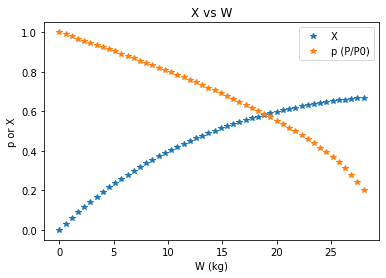

In [7]:
X_odeint = sol[:,0]
P_odeint = sol[:,1]
plt.plot(W_range, X_odeint, '*', label='X')
plt.plot(W_range, P_odeint, '*', label='p (P/P0)')
#We'll show a faster way of doing the above four lines below
plt.title('X vs W')
plt.xlabel('W (kg)')
plt.ylabel('p or X')
plt.legend()

In [8]:
#Sometimes things go wrong with integration, and it's useful to track all output from the algorithm:
sol2, info = odeint(deriv, init, W_range, full_output=1)

In [9]:
#For example, since this is an adapative method, we could look at the actual W points that where values were calculated
W_actual=info['tcur'] #Extract the dictionary 'tcur' from the aditional odeint data
y = [0.2]*len(W_actual) #Generate a list of y's to add to plot to show actual timesteps

In [10]:
X_odeint = sol[:,0]
P_odeint = sol[:,1]
plt.plot(W_range, X_odeint, '*', label='X')
plt.plot(W_range, P_odeint, '*', label='p (P/P0)')
plt.title('X vs W')
plt.xlabel('W (kg)')
plt.ylabel('p or X')
#Up to this point is same as before, now adding 
plt.plot(W_actual, y, 'o', label = 'W')
plt.legend()

In [11]:
#Exploring other data returned by odeint
#dictionaries: tsw, nst, nfe, etc.
print(info['nfe']) #This is the cumulative number of function evaluations

[ 19  25  29  31  35  37  37  39  39  41  41  43  43  45  45  49  49  51
  53  53  55  59  59  61  63  65  65  69  71  73  75  79  81  83  85  89
  93  95  99 103 109 113 119 123 131 139 149 159 173]


In [12]:
#A faster way to plot each of the trajacetories that we solved:
np_sol = np.asarray(sol)
labels = ['X', 'p']
for col in range(np_sol.shape[1]): 
    plt.plot(W_range, np_sol[:,col], label=labels[col])
plt.legend()

Let's look at the above code in a little more detail, since at first glance it's a little confusing. We make use of three functions here:

1) **np.asarray()** converts a standard python array to a numpy array, a data type that has some very useful functions associated with it

2) **array.shape()** returns the size of an array in each dimension. For a two-dimensional array, it returns the list [rows, columns]. By specifically referring to shape[1], we are returning the number of columns in the array

3) **range(start,stop,step)** returns a list of numbers from start position to stop position incremented by step. Only STOP is a required argument. By default, if only STOP is given, this function returns a list from 0->stop in increments of 1. Note that because of Python's 0-indexing, position 2 is index 1, so range(2), gives us 0,1

so, combining range(np_sol.shape[1]) gives us the list 0,1. 

The for loop we set up iterates over this range, with the variable col taking on each value. We then use that value to extract the specific column and plot it, with the associated label. The code below demonstrates the various aspects discussed here.

In [13]:
np_sol.shape
#50 rows, 2 columns

(50, 2)

In [14]:
range(2)
for n in range(2):
  print(n)

0
1


## A word about variable access
In this example, we defined alpha, FA0, and other variables **globally** (outside of a specific function), e.g. they can be accessed in any function we write. This *can* be really dangerous, depending on the order cells are run within a notebook, and can have unintended consequences. Sometimes it is better to keep variables defined **locally** e.g. within a function, and then pass them off to another function when it is called. For most user-defined functions, this is straightforward, e.g.:

In [14]:
def execute():
    x = np.linspace(0,10,11)
    x2 = multiply_by_2(x)
    print(x2)
    
def multiply_by_2(x):
    return 2.0*x

execute() #Run the function loop_over_x and print the output

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]


In [15]:
#But now if I try to access x
try:
    print(x)
except Exception as e:
    print("Oops, that caused an error because ", str(e))

Oops, that caused an error because  name 'x' is not defined


This is a **good thing**, because you can't accidentally change the definition of x in "execute" in another function that you write. 

One annoying exception to this simplicity is when using odeint (and other built-in functions) to pass things like FA0 and alpha to your derivative function. Let's take the toy example:
$$\frac{dX}{dt}=AX^b$$

In [16]:
def deriv(X,t,a,b):
    #If I want the calling function to control a and b, I can't define them here!
    dXdt = a*X**b
    return dXdt

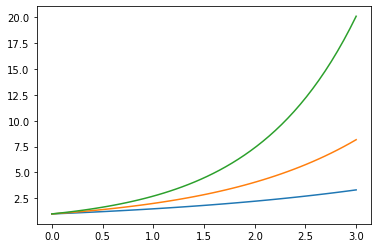

In [17]:
def run_solver(a,b):
    X0 = 1.0
    t_range = np.linspace(0, 3.0, 50)
    sol = odeint(deriv,X0, t_range, args=(a,b)) #Note the syntax and use of "args" here. The parentheses indicate these values are tuples (immutable)
    plt.plot(t_range,sol[:,0])

for a in np.linspace(0.4, 1.0, 3):
    run_solver(a,1.0)

    #This is a cleaner way to input variables into your derivative function

## How pressure drop affects conversion
The beauty of setting up this problem computationally is htat we can very quickly and easily explore the effect of changing various parameters on the solution. Let's do that now, examining the impact of $\alpha$ and $\epsilon$

In the first case, let's look at the absence of pressure drop ($\alpha=0$) compared to the base case. First, let's clean up our integrating function to be able to pass in these values locally, so that we don't screw up the global definitions above

In [15]:
def deriv2(current, W, alpha_loc, epsilon_loc): #Redefining _loc as local version of the variables
    X = current[0]
    p = current[1]
    ra = -1.0*k*(1.0-X)/(1+epsilon_loc*X)*p
    dXdW = -ra/FA0
    dpdW = -alpha_loc*(1.0+epsilon_loc*X)/(2.0*p)
    return dXdW,dpdW

In [32]:
def vary_alpha(alpha_range):
    labels = ['X', 'p']
    for i in alpha_range:
        sol3 = odeint(deriv2, init, W_range, args=(i, epsilon)) #Solve using the new function
        np_sol = np.asarray(sol3) #Convert to numpy array
        for col in range(np_sol.shape[1]): 
            plt.plot(W_range, np_sol[:,col], label=labels[col]+', alpha = '+str(i))
        plt.legend()
        
vary_alpha([0.0, alpha]) #Test 0 and the original range

Notice that conversion is higher without pressure drop. This makes sense for  reaction with order >0, because as pressure increases, concentration increases, and that improves reaction rate

Now let's look at the impact of epsilon, examining three conditions:
* Negative
* Zero
* Positive

In [38]:
def vary_epsilon(epsilon_range):
    labels = ['X', 'p']
    new_W_range = np.linspace(0.0, 20.0, 100)
    for i in epsilon_range:
        sol3 = odeint(deriv2, init, new_W_range, args=(alpha, i)) #Solve using the new function
        np_sol = np.asarray(sol3) #Convert to numpy array
        for col in range(np_sol.shape[1]): 
            plt.plot(new_W_range, np_sol[:,col], label=labels[col]+', epsilon = '+str(i))
        plt.legend()
        
vary_epsilon([-1, 0.0, 1]) #Test 0 and +/- 1

Notice that the value of $\epsilon$ can either worsen or mitigate pressure drop through the reactor, and therefore also affect conversion. Think about this yourself and try to come up with an explanation in your own terms